<!--<div style=float:right><img src="assets/img/applied-logo_100px.png"></img></div>-->

#### Applied AI Internal Demo Project
## Survival Analysis HDD

Demo some capabilities of parametric and nonparametric survival analysis using Python tools.  
Using hard drive survival data from the [BackBlaze HDD tests](https://www.backblaze.com/blog/hard-drive-data-feb2015/)


# 04_CoxPHModel

+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load-Data)
    
    
+ [Cox Proportional Hazards Modeling](#Cox-Proportional-Hazards-Modeling)
    + [Transform raw dataframe into design matrix](#Transform-raw-dataframe-into-design-matrix)
    + [Fit CoxPH model](#Fit-CoxPH-model)
    + [View the baseline hazard rate](#View-the-baseline-hazard-rate)
    + [View the summary of model coefficients](#View-the-summary-of-model-coefficients)
    + [Evaluate model performance using concordance](#Evaluate-model-performance-using-concordance)

# Setup

In [1]:
## Interactive magics - comment out if running from another script
%matplotlib inline
%qtconsole --colors=linux --ConsoleWidget.font_size=12 --ConsoleWidget.font_family='Consolas'

In [2]:
from collections import OrderedDict
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lifelines as sa
from lifelines.utils import concordance_index, k_fold_cross_validation
import patsy as pt

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set default styles for plotting via pandas, seaborn and matplotlib
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
sns.set(style='darkgrid')
cmap_clrbld = ['#777777','#E69F00','#56B4E9','#D3C511'
               ,'#009E73','#8D42F0','#0072B2','#D55E00','#CC79A7']
plt.rcParams['axes.color_cycle'] = cmap_clrbld
plt.rcParams['figure.figsize'] = 14, 6

np.random.seed(0)

## Local Functions

In [3]:
def estimate_cond_mean(S):
    """ Quick & dirty estimate of conditional mean lifetime """
    fstar = -S.diff() / (1-S.iloc[-1,0])
    Sstar = (S-S.iloc[-1,0]) / (1-S.iloc[-1,0])
    llstar = fstar / Sstar
  
    llstar[pd.isnull(llstar)] = 0
    llstar = llstar[np.isfinite(llstar)]
    llstarcs = llstar.cumsum().reset_index()
    llstarcs['timelinediff'] = np.append(llstarcs['timeline'].diff().values[1:],0)
    llstarcs['auc'] = llstarcs['timelinediff'] * llstarcs['KM_estimate']
    return np.nansum(llstarcs['auc']).round()


## Load Data

In [4]:
cnx = sqlite3.connect('data/drive_stats.db')
df = pd.read_sql('select * from drive_survival_prepared', con=cnx
                 ,index_col='diskid', parse_dates=['mindate','maxdate'])

In [5]:
print(df.shape)
df.head()

(47252, 11)


,model,mindate,maxdate,nrecords,minhours,maxhours,failed,manufacturer,capacity,mindateym,maxdateym
diskid,,,,,,,,,,,
5XW004AJ,ST31500541AS,2013-04-20,2014-12-31,564,21697,36586,0,SEAGATE,1.5TB,201304,201412
5XW004Q0,ST31500541AS,2013-04-10,2014-12-31,574,29341,44471,0,SEAGATE,1.5TB,201304,201412
5XW008MX,ST31500541AS,2013-04-10,2014-12-31,574,29341,44471,0,SEAGATE,1.5TB,201304,201412
5XW00B95,ST31500541AS,2013-04-10,2014-12-31,574,26920,42049,0,SEAGATE,1.5TB,201304,201412
5XW00E5M,ST32000542AS,2013-05-16,2014-07-31,386,22036,32614,0,SEAGATE,2.0TB,201305,201407


---

# Cox Proportional Hazards Modelling

## Transform raw dataframe into design matrix

The Cox PH model gives a semi-parametric method of estimating the hazard function at time $t$ given a baseline hazard that's modified by a set of covariates:

$$\lambda(t|X) = \lambda_0(t)\exp(\beta_1X_1 + \cdots + \beta_pX_p) = \lambda_0(t)\exp(\bf{\beta}\bf{X})$$

where $\lambda_0(t)$ is the non-parametric baseline hazard function and $\bf{\beta}\bf{X}$ is a linear parametric model using features of the individuals, transformed by an exponential function.

... we will use the `patsy` package to transform our row-format dataframe into $\bf{X}$. 

Note that by default, the first factor in each feature will be used in the intercept, which sets the _baseline hazard rate_, to which all other factor combinations are compared. In this case, that will be `HGST` and `1.5TB`.

In [52]:
modelspec = 'manufacturer + capacity'

dft = pt.dmatrix(modelspec, df, return_type='dataframe')
design_info = dft.design_info
dft = dft.join(df[['maxhours','failed']])

## NOTE: CoxPHFitter expects reduced-rank design matrix WITHOUT intercept
## https://courses.nus.edu.sg/course/stacar/internet/st3242/handouts/notes3.pdf
del dft['Intercept']
dft.head().T

diskid,5XW004AJ,5XW004Q0,5XW008MX,5XW00B95,5XW00E5M
manufacturer[T.SEAGATE],1,1,1,1,1
manufacturer[T.WDC],0,0,0,0,0
capacity[T.2.0TB],0,0,0,0,1
capacity[T.3.0TB],0,0,0,0,0
capacity[T.4.0TB],0,0,0,0,0
capacity[T.6.0TB],0,0,0,0,0
maxhours,36586,44471,44471,42049,32614
failed,0,0,0,0,0


**NOTE:**
+ This is a view of the top 5 rows of the design matrix, transposed so it fits easier in view
+ You can see the boolean representation of the feature values for each disk, for example
    + diskid 5XW004AJ is a Seagate 1.5TB drive with 36586 hours of power-on and no failure
    + diskid 5XW00E5M is a Seagate 2.0TB drive with 32614 hours of power-on and no failure


## Fit CoxPH model

In [7]:
cx = sa.CoxPHFitter(normalize=False)
cx.fit(df=dft, duration_col='maxhours', event_col='failed'
           ,show_progress=True, include_likelihood=True)

Convergence completed after 8 iterations.


<lifelines.CoxPHFitter: fitted with 47252 observations, 44428 censored>

The `fit()` method has run the CoxPH partial regression and stored the results on the `cx` object

## View the baseline hazard rate

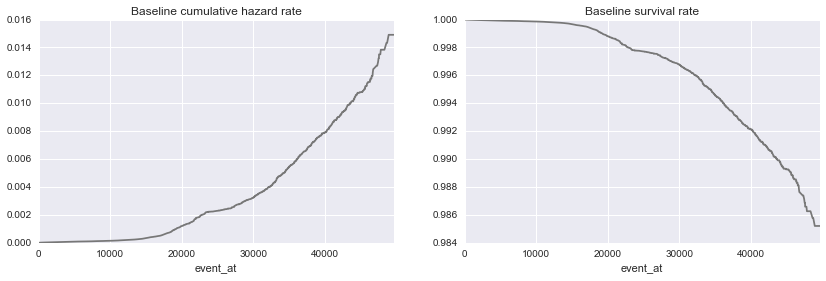

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, sharex=True, figsize=(14,4))
cx.baseline_cumulative_hazard_.plot(ax=axes[0,0], legend=False
                ,title='Baseline cumulative hazard rate')
cx.baseline_survival_.plot(ax=axes[0,1], legend=False
                ,title='Baseline survival rate')

**Observe:**
+ Here we see our baseline cumulative hazard rate $\Lambda = \sum_t{\lambda_0(t)}$ and the computed baseline survival rate $S = e^{-\Lambda}$
+ The baseline cumulative hazard rate is very modest in this case, since it's set by 1.5TB capcities and HGST drives which appear to be quite reliable.
+ Reading the cumulative baseline hazard rate, we see for example that by ~44,000 hours (5 years) elapsed, the baseline probability of drive failure is 1%. This seems low, but of course, the baseline will be modified by $exp(\bf{\beta}\bf{X})$.

## View the summary of model coefficients

In [9]:
cx.summary

,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
manufacturer[T.SEAGATE],3.100713,22.213774,0.074905,41.395366,0.000000e+00,2.953870,3.247556
manufacturer[T.WDC],2.465773,11.772577,0.141731,17.397539,8.612413e-68,2.187924,2.743622
capacity[T.2.0TB],1.203798,3.332752,0.112477,10.702612,9.894919e-27,0.983299,1.424298
capacity[T.3.0TB],2.613823,13.651145,0.079818,32.747221,3.325801e-235,2.457348,2.770299
capacity[T.4.0TB],2.331483,10.293193,0.106084,21.977731,4.703864e-107,2.123516,2.539449
capacity[T.6.0TB],2.005148,7.427189,1.007696,1.989834,4.660918e-02,0.029666,3.980629


The proportional nature of the hazard coefficients can be seen clearly..

**Observe:**
+ Manufacturers:
    + A typical Seagate drive has a mean hazard rate exp(3.10) == 22.2x that of an HGST drive (remember HGST is on the baseline for this model), and a WDC drive has a hazard rate 11.77x that of an HGST drive
+ Capacities:
    + A 2TB drive would appear to be exp(0.98)x to exp(1.42)x more likely to fail than a 1.5TB drive, mean exp(1.20)x == 3.33x.
    + Looking back to the [Kaplan-Meier model results](../notebooks/03_KaplanMeierModel.ipynb#Lifetime-by-Manufacturer-by-Capacity) we can see this is mostly due to failures in the Seagate 2TB drives, since there are no HGST 1.5TB drives and few from WDC
    + A 4TB drive would appear to be exp(2.33)x == 10.3x more likely to fail than a 1.5TB drive, but compared with a 3TB drive, is exp(2.33 - 2.61) == 0.76x as likely to fail: an increase in reliability _and_ capacity.    

##### Lets view those ranges on the $exp(\bf\beta)$ coefficients

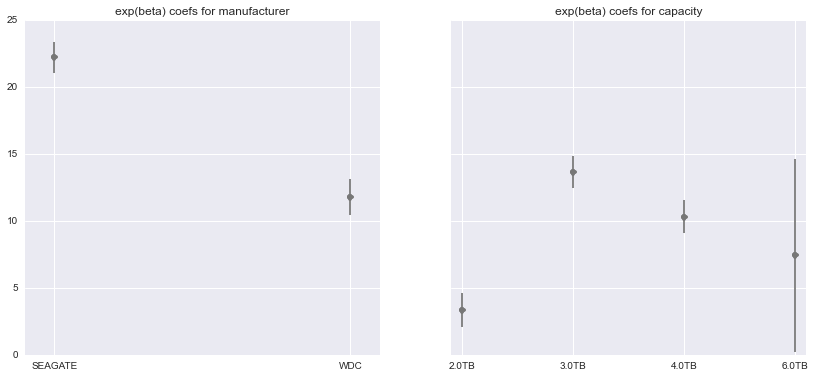

In [51]:
smy = cx.summary.copy().reset_index()
smy['type'] = smy['index'].apply(lambda x: 'mfr' if x[:1]=='m' else 'cap')
smy['err'] = smy['upper 0.95'] - smy['coef']

fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(14,6), sharey=True)
fig.canvas.draw()
for j, sel in enumerate(['mfr','cap']):
    smysub = smy.loc[smy['type']==sel].copy()
    axes[0,j].errorbar(x=np.arange(smysub.shape[0]), y=np.exp(smysub['coef'])
                       ,marker='o', linestyle='', yerr=np.exp(smysub['err']))
    axes[0,j].set_title('exp(beta) coefs for {}'.format(['manufacturer','capacity'][j]))
    axes[0,j].set_xlim([-0.1, len(smysub) - 0.9])
    axes[0,j].set_xticks(np.arange(smysub.shape[0]))
    axes[0,j].set_xticklabels([t.split('[')[1][2:-1] for t in smysub['index']])


**Observe:**
+ The proportional hazards really are very different amongst the drives, with Seagate and 3TB drives noticably different to the rest
+ The uncertainty in the beta coeffs is far more clear in this view, for example
    + the 6TB drives are not well-represented (~1% of all drives) and so have a large 95% confidence interval
    + WDC drives appear to be significantly more reliable than Seagate


## Evaluate model performance using concordance

The `lifelines` package has a couple of convenience functions to let us very easily evaluate model performance:
+ `concordance_index` which computes the concordance index - the overall probability that predicted and actual events occur in the same ranked order (see more at http://papers.nips.cc/paper/3375-on-ranking-in-survival-analysis-bounds-on-the-concordance-index.pdf)
+ `k_fold_cross_validation` which divides the dataset n into two subsets with n(k-1)/k rows and n/k rows, then uses the larger set to train and the smaller set to test the model using the concordance measure. The 'fold' part means it runs repeatedly over different subsets so that each row in the data is used for training and for test.

Paraphrasing the lifelines docs: concordance is a generalisation of the area-under-curve (AUC) measure and interpreted similarly:
+ 0.5 is the expected result from random predictions,
+ 1.0 is perfect concordance and,
+ 0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)

A concordance score between 0.6 and 0.8 would indicate a well-performing model.

In [53]:
cx1 = sa.CoxPHFitter(normalize=False)
scores = k_fold_cross_validation(cx1, dft, k=5
        ,duration_col='maxhours',event_col='failed', predictor='predict_expectation')

(0.5, 1)

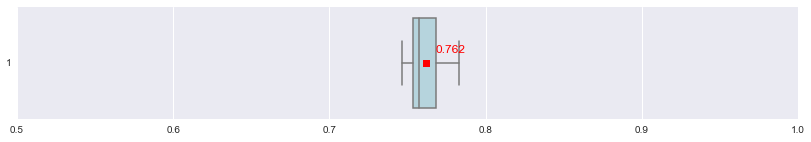

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,2))
sns.boxplot(scores, vert=False, color='lightblue', ax=axes, showmeans=True)
axes.annotate('{:.3f}'.format(np.mean(scores)), xy=(np.mean(scores),1), xycoords='data'
                 ,xytext=(10, 10), textcoords='offset points', color='r', fontsize=12)
axes.set_xlim([0.5,1])

**Observe:**
+ 5-fold cross-validation reports a mean concordance of 0.762, a very respectable number which means we can expect our model to make reasonable predictions about new harddrives and about the future of our population of harddrives.

---
<!--<div style=float:right><img src=assets/img/applied-logo_100px.png></img></div>-->
**&copy; Applied AI Ltd 2015**  
<a href='http://www.applied.ai'>applied.ai</a>